In [63]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

In [64]:
tsi = pd.read_csv('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/tsi.csv')
tsi['date'] = pd.to_datetime(tsi[['year', 'month']].assign(DAY=1))
ssn = tsi.drop(columns=['year', 'month'], axis=1)

In [65]:
def prepare_for_prophet(df, value_col):
    prophet_df = df.rename(columns={'date': 'ds', value_col: 'y'})
    return prophet_df[['ds', 'y']]

In [83]:
def create_prophet_model(df, cycle_period=11):
    m = Prophet(
        seasonality_mode='multiplicative',
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.5, # in 
        interval_width=0.90  # confidence interval
    )
    
    m.add_seasonality(
        name='solar_cycle',
        period=365.25 * cycle_period,
        fourier_order=9,
    )
    
    m.fit(df)
    return m

In [84]:
def make_forecast(model, periods=72, freq='MS'):
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
    
    return forecast

In [85]:
def calculate_metrics(original_data, forecast, start_date=None):
    merged = pd.merge(
        original_data, 
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
        left_on='ds', 
        right_on='ds', 
        how='inner'
    )
    
    if start_date:
        merged = merged[merged['ds'] >= start_date]
    
    if len(merged) == 0:
        return {'picp': None, 'mpiw': None}
    
    # PICP (prediction interval coverage probability)
    within_pi = ((merged['y'] >= merged['yhat_lower']) & 
                 (merged['y'] <= merged['yhat_upper']))
    picp = within_pi.mean() * 100
    
    # MPIW (mean prediction interval width)
    mpiw = (merged['yhat_upper'] - merged['yhat_lower']).mean()
    
    return {'picp': picp, 'mpiw': mpiw}

In [86]:
def plot_solar_cycle_forecast(original_data, forecast, title, y_label, 
                             cycle_25_start='2020-01-01', 
                             plot_start='2010-01-01', 
                             plot_end='2030-12-31',
                             latest_data_date=None):
    
    plt.figure(figsize=(12, 8))
    
    # Filter data for plotting period
    mask_period = (forecast['ds'] >= plot_start) & (forecast['ds'] <= plot_end)
    plot_forecast = forecast[mask_period]
    
    # Filter original data for plotting period
    mask_orig = (original_data['ds'] >= plot_start) & (original_data['ds'] <= plot_end)
    plot_original = original_data[mask_orig]
    
    # Plot uncertainty interval (only from cycle 25 onwards)
    mask_c25 = (plot_forecast['ds'] >= cycle_25_start)
    plt.fill_between(
        plot_forecast.loc[mask_c25, 'ds'],
        plot_forecast.loc[mask_c25, 'yhat_lower'],
        plot_forecast.loc[mask_c25, 'yhat_upper'],
        color='lightblue', alpha=0.5,
        label='Uncertainty Interval'
    )
    

    plt.plot(plot_forecast['ds'], plot_forecast['yhat'], color='steelblue', linewidth=2, label='Forecast')
    
    # Historical data 
    plt.scatter(plot_original['ds'], plot_original['y'], color='black', s=10, alpha=0.7, label='Historical TSI')
    
    if latest_data_date:
        plt.axvline(x=pd.to_datetime(latest_data_date), color='red', linestyle='--', linewidth=2, label='Latest Data')
    
    plt.axvspan(pd.to_datetime(cycle_25_start), pd.to_datetime(plot_end), alpha=0.1, color='yellow', label='Solar Cycle 25')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    ax = plt.gca()
    ax.xaxis.set_major_locator(YearLocator(5))  # Show year every 5 years
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.xticks(rotation=0, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    return plt

In [87]:
tsi_prophet = prepare_for_prophet(tsi, 'tsi')

tsi_model = create_prophet_model(tsi_prophet)

tsi_forecast = make_forecast(tsi_model)

09:38:55 - cmdstanpy - INFO - Chain [1] start processing
09:38:56 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
cycle_25_start = '2020-01-01'
latest_data_date = '2024-07-01'

In [89]:
tsi_metrics = calculate_metrics(tsi_prophet, tsi_forecast, start_date=cycle_25_start)

print("\nTSI Forecast Metrics for Cycle 25 (historical portion):")
print(f"PICP: {tsi_metrics['picp']:.2f}%")
print(f"MPIW: {tsi_metrics['mpiw']:.2f}")


TSI Forecast Metrics for Cycle 25 (historical portion):
PICP: 80.36%
MPIW: 0.35


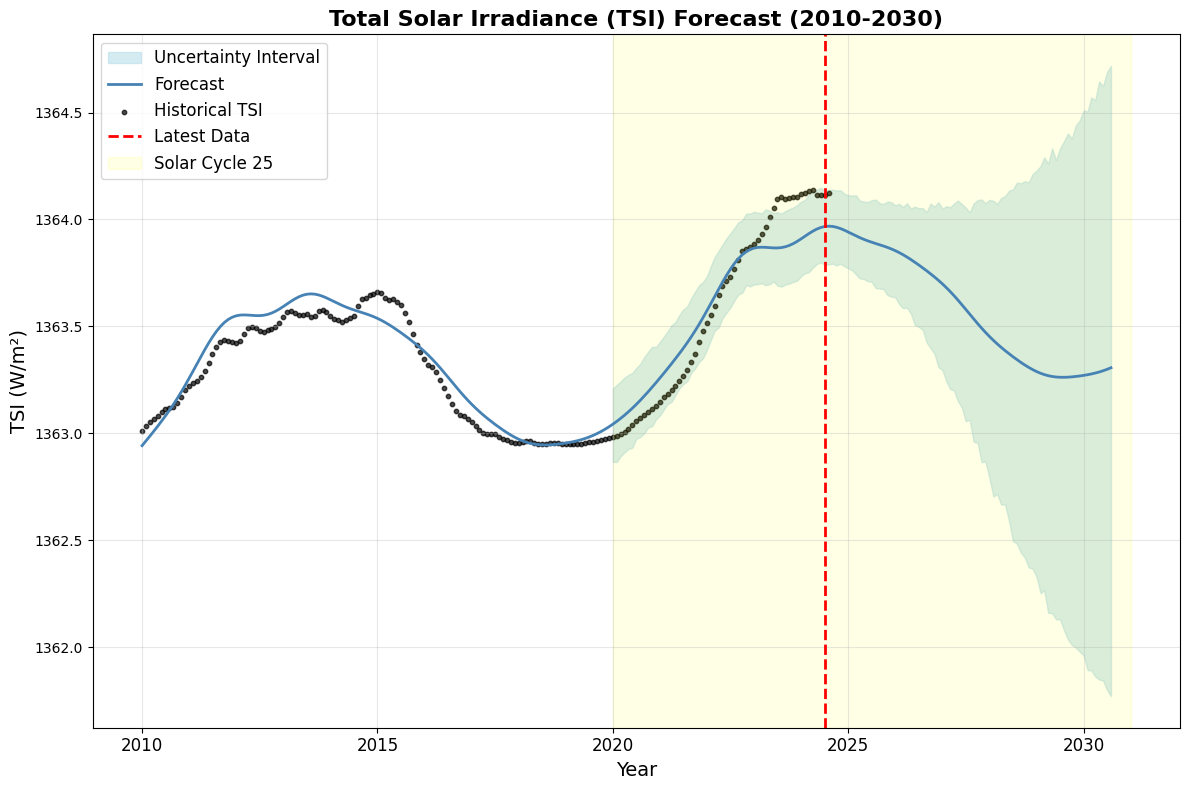

In [90]:
tsi_plot = plot_solar_cycle_forecast(
    tsi_prophet, tsi_forecast, 
    'Total Solar Irradiance (TSI) Forecast (2010-2030)', 
    'TSI (W/m²)',
    cycle_25_start=cycle_25_start,
    plot_start='2010-01-01',
    plot_end='2030-12-31',
    latest_data_date=latest_data_date
)
tsi_plot.show()

In [91]:
tsi_cycle_25 = tsi_forecast[(tsi_forecast['ds'] >= cycle_25_start) & 
                           (tsi_forecast['ds'] <= '2030-12-31')]
tsi_max_row = tsi_cycle_25.loc[tsi_cycle_25['yhat'].idxmax()]

print(f"\nTSI Peak Prediction for Cycle 25:")
print(f"Predicted peak date: {tsi_max_row['ds'].strftime('%B %Y')}")
print(f"Predicted peak TSI: {tsi_max_row['yhat']:.6f} W/m²")
print(f"90% confidence interval: [{tsi_max_row['yhat_lower']:.6f}, {tsi_max_row['yhat_upper']:.6f}] W/m²")


TSI Peak Prediction for Cycle 25:
Predicted peak date: August 2024
Predicted peak TSI: 1363.968778 W/m²
90% confidence interval: [1363.789567, 1364.138370] W/m²
